todo replace one-hot encoding + linear by embedding layer

In [4]:
tm = TimeMachine()
corpus, vocab = tm.build()

In [5]:
len(corpus), len(vocab)

(174215, 28)

<br>

```{figure} ../../../img/nn/04-char-rnn.svg
---
width: 550px
name: 04-char-rnn
align: center
---
Character-level RNN language model for predicting the next character at each step.  [Source](https://www.d2l.ai/chapter_recurrent-neural-networks/rnn.html)
```

Our goal in the following language model is to predict the next token. 
Hence, we only need the final state.

In [6]:
class RNNLanguageModel(nn.Module):
    """RNN based language model."""
    def __init__(self, dim_inputs, dim_hidden, vocab_size):
        super().__init__()
        self.rnn = SimpleRNN(dim_inputs=dim_inputs, dim_hidden=dim_hidden)
        self.out_layer = nn.Linear(dim_hidden, vocab_size)

    def forward(self, x, state=None):
        outs, _ = self.rnn(x, state)
        logits = self.out_layer(outs)   # (B, T, C)
        return logits.permute(0, 2, 1)  # F.cross_entropy expects (B, C, T)

In [7]:
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, corpus: list, seq_len: int, vocab_size: int):
        super().__init__()
        self.corpus = corpus
        self.seq_len = seq_len
        self.vocab_size = vocab_size

    def __getitem__(self, i):
        c = torch.tensor(self.corpus[i: i + self.seq_len + 1])
        x, y = c[:-1], c[1:]
        x = F.one_hot(x, num_classes=self.vocab_size).float()
        return x, y
    
    def __len__(self):
        return len(self.corpus) - self.seq_len

In [8]:
from torch.utils.data import random_split

dataset = SequenceDataset(corpus, seq_len=30, vocab_size=len(vocab))
train_dataset, valid_dataset = random_split(dataset, [0.80, 0.20])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [9]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)
print("target:", y[0][:5])
print("inputs:", torch.argmax(x, dim=-1)[0][:5])

torch.Size([128, 30, 28]) torch.Size([128, 30])
target: tensor([10, 21, 10, 16, 15])
inputs: tensor([20, 10, 21, 10, 16])


each element of a batch contains $T$ prediction instances for training. 
prediction is done at each step, while state update is done at each step as well.
recall that the model collects the output at every step. below are logits for $t = 1, \ldots, 30.$ At each step, the hidden state is updated before making the next prediction. 

the model is evaluated at every time step and not just with fixed length inputs. state starts at zero so its necessasry to warm the model up

In [10]:
import torch.nn.functional as F

model = RNNLanguageModel(28, 5, len(vocab))
loss = F.cross_entropy(model(x), y)  # model(x): (B, T, C)
loss

tensor(3.4088, grad_fn=<NllLoss2DBackward0>)

To train RNNs, it is common to use **gradient clipping**. RNNs are deep in another sense, i.e. in sequence length since we apply the state update function $f$ for each sequence element. Hence, during BP, we get matrix products of length $O(T).$ This causes gradients to explode or vanish resulting in numerical instability. A direct solution to exploding gradients is simply to clip them. Here we project them to a ball of radius $\xi.$ Thus,

$$
\boldsymbol{\mathsf{g}} \leftarrow \min \left(1, \frac{\xi}{\| \boldsymbol{\mathsf{g}} \|} \right) \boldsymbol{\mathsf{g}} = \min \left({\| \boldsymbol{\mathsf{g}}\|,\, {\xi}} \right) \frac{\boldsymbol{\mathsf{g}}}{\| {\boldsymbol{\mathsf{g}}} \|}.
$$

First, the gradient is still in the same direction but clipped in norm to $\xi.$ 
So when $\| \boldsymbol{\mathsf{g}} \| \leq \xi$, the gradient is unchanged. On the other hand, when 
$\| \boldsymbol{\mathsf{g}} \| > \xi$, the above ratio goes out of the $\min$ operation, and the gradient is scaled to have norm $\xi.$

In the following implementation, the norm is computed over the individual parameter gradients, as if the norms of the individual gradients were concatenated into a single vector. The operation modifies the tensors in-place.

In [11]:
from tqdm import tqdm
import torch.nn.functional as F


def clip_grad_norm(model, max_norm: float):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > max_norm:
        for p in params:
            p.grad[:] *= max_norm / norm   # [:] = shallow copy, in-place


DEVICE = "mps"
lr = 0.01
epochs = 5
max_norm = 1.0
model = RNNLanguageModel(len(vocab), 64, len(vocab))
model.to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=lr)

def train_step(model, x, y, max_norm) -> float:
    loss = F.cross_entropy(model(x), y)
    loss.backward()
    clip_grad_norm(model, max_norm=max_norm)
    optim.step()
    optim.zero_grad()
    return loss.item()

@torch.no_grad()
def valid_step(model, x, y) -> float:
    loss = F.cross_entropy(model(x), y)
    return loss.item()

train_losses = []
valid_losses = []
for e in tqdm(range(epochs)):
    for t, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        loss = train_step(model, x, y, max_norm)
        train_losses.append(loss)

        if t % 5 == 0:
            xv, yv = next(iter(valid_loader))
            xv, yv = xv.to(DEVICE), yv.to(DEVICE)
            valid_losses.append(valid_step(model, xv, yv))


  0%|                                                       | 0/5 [00:00<?, ?it/s]


 20%|█████████▍                                     | 1/5 [00:45<03:00, 45.24s/it]


 40%|██████████████████▊                            | 2/5 [01:27<02:10, 43.42s/it]


 60%|████████████████████████████▏                  | 3/5 [02:10<01:26, 43.09s/it]


 80%|█████████████████████████████████████▌         | 4/5 [02:55<00:44, 44.17s/it]


100%|███████████████████████████████████████████████| 5/5 [03:40<00:00, 44.23s/it]


100%|███████████████████████████████████████████████| 5/5 [03:40<00:00, 44.05s/it]

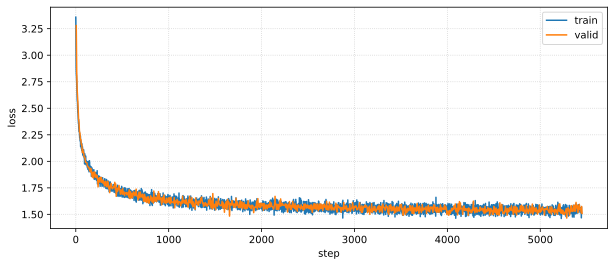

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="train")
plt.plot(np.array(range(1, len(valid_losses) + 1)) * 5, valid_losses, label="valid")
plt.grid(linestyle="dotted", alpha=0.6)
plt.ylabel("loss")
plt.xlabel("step")
plt.legend();

Note we addressed problem of exploding gradients, but not vanishing gradients.

## Decoding

Sampling
- first update state after processing warmup text
- RNN samples one character at a time

In [13]:
def inp(indices: list[int]):
    """Helper to preprocess indices (T,) to (1, T, V) as model input."""
    n = len(vocab)
    return F.one_hot(torch.tensor(indices), n).float().view(1, -1, n).to(DEVICE)
    
def sample_token(out, temp=1.0):
    """Sample next token from output logits with softmax temperature."""
    p = torch.exp(out / temp)   # higher temp => more uniform, i.e. exp ~ 1
    return torch.multinomial(p, num_samples=1).item()

def predict(model, vocab, warmup: str, num_preds: int, temp=1.0):
    """Simulate RNN character generation one at a time."""
    model.to(DEVICE)
    warmup_indices = vocab[list(warmup.lower())]

    # Predict over warmup text. Get final state
    outs, state = model.rnn(inp(warmup_indices))

    # Next token sampling and state update. Start w/ state & token after warmup
    next_token_idx = lambda model, out: sample_token(model.out_layer(out), temp)
    indices = [next_token_idx(model, outs[0, -1, :])]
    for t in range(num_preds - 1):
        out, state = model.rnn(inp([indices[-1]]), state)
        indices.append(next_token_idx(model, out[0, 0, :]))

    return "".join(vocab.to_tokens(warmup_indices + indices))


warmup = "mr williams i understan"
generated_text = []
for i in range(4):
    temp = 0.2 + 0.30 * i
    s = predict(model, vocab, warmup, num_preds=100, temp=temp)
    generated_text.append(f"temp={temp:.1f}   {s}")

print("\n".join(generated_text))

temp=0.2   mr williams i understand i saw the thing the sun the strengr the strange the strengr a strengr and the sun the strengr the 
temp=0.5   mr williams i understands a strenge in the incomp sime the white it was a the cold of the by in the white but said then i s
temp=0.8   mr williams i understanisave ning strence went away seal of my for moxzendity from the peecently of the exactal through in 
temp=1.1   mr williams i understanding nessy vay in markelol hore was got agains swaysions uned the remars weach the sitfe it wexce ou


time traveller mentioned?!

higher temp -> more random, lower temp -> argmax. 

Our only goal is to have it complete the word `understand`. 

One thing to note is that our sampling algorithm only gets the largest probability token which makes it prone to cycles. Also, it would be nice if text generation does some backtracking, i.e. looking at the probability of the text when we add a new character, as well as characters that will follow the added character.

network can generate output with variable-length warmup prompt.

## Appendix: Simple RNN in PyTorch

We can also use the PyTorch RNN module in our language model:

In [14]:
rnn = nn.RNN(d, h, batch_first=True)
x = torch.randn(B, T, d)
outs, state = rnn(x)
assert outs.shape == (B, T, h)
assert state.shape == (1, B, h)
assert torch.abs(outs[:, -1, :] - state).max() < 1e-8

## Appendix: BPTT

- Recall state is updated at each time step, while the parameters of the RNN layer are fixed.
- Thus, we have to track the dependencies across time steps, where the RNN parameters are shared through time steps.
- This is BPTT or BP for sequence models.
- Hopefully, this discussion will bring some precision to the notion of vanishing and exploding gradients. 
- This procedure requires us to expand (or unroll) the computational graph of an RNN one time step at a time. The unrolled RNN is essentially a feedforward neural network with the special property that the same parameters are repeated throughout the unrolled network, appearing at each time step.
- Then we can apply the usual BP through the unrolled net.
- For long sequences, e.g. text sequences containing over a thousand tokens, this poses problems both from a computational (too much memory to compress in a single state vector) and optimization (numerical instability) standpoint. Input from the first step passes through over 1000 matrix products before arriving at the output, and another 1000 matrix products are required to compute the gradient.

want to see
- arrow of time (effect of time steps)
- has a short memory

$a_t = b_t + c_t a_{t - 1}$

$a_t = b_t + c_t (b_{t - 1} + c_{t-1} a_{t-2})$

$a_t = b_t + c_t (b_{t - 1} + c_{t-1} (b_{t - 2} + c_{t-2} a_{t-3}))$

Product propagates inwards:

$a_t = b_t + c_t b_{t - 1} + c_t c_{t-1} b_{t - 2} +  c_t c_{t-1}c_{t-2} a_{t-3}$

$$a_t = b_t + \sum_{i=1}^{t-1} \left( \prod_{j = i + 1}^t c_j\right) b_{i}$$

assuming $a_0 = 0.$

```{figure} ../../../img/nn/04-rnn-backprop.svg
---
width: 500px
align: center
---
RNN cell backpropation. Note that the matrices $\boldsymbol{\mathsf{W}}, \boldsymbol{\mathsf{U}},$ and $\boldsymbol{\mathsf{V}}$ are shared across time steps.
```

Recall:

$$
\begin{aligned}
\boldsymbol{\mathsf{H}}_t &= f(\boldsymbol{\mathsf{X}}_t \boldsymbol{\mathsf{U}} + \boldsymbol{\mathsf{H}}_{t-1} \boldsymbol{\mathsf{W}} + \boldsymbol{\mathsf{b}}) \\
\boldsymbol{\mathsf{Y}}_t &= \boldsymbol{\mathsf{H}}_t \boldsymbol{\mathsf{V}} + \boldsymbol{\mathsf{c}} \\
\boldsymbol{\mathsf{H}}_{t+1} &= f(\boldsymbol{\mathsf{X}}_{t+1} \boldsymbol{\mathsf{U}} + \boldsymbol{\mathsf{H}}_{t} \boldsymbol{\mathsf{W}} + \boldsymbol{\mathsf{b}}).
\end{aligned}
$$

Assume that there are incoming gradients $\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{y}}_t}$ and $\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{h}}_{t+1}}$ from the next layer.
We start by calculating the gradient with respect to $\boldsymbol{\mathsf{V}}.$ Here we abstract the product between two tensors on appropriate indices by using the $\text{prod}$ notation. The exact formula can be recovered by index notation. Let $f$ be an activation function. Upper case indicate that a non-parameter tensor's first dimension is the batch dimension. Then, 

$$
\begin{aligned}
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{V}}}}_{(h, q)} &= \sum_{t=1}^T \text{prod}\left(\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Y}}_t}, \frac{\partial \boldsymbol{\mathsf{Y}}_t}{\partial \boldsymbol{\mathsf{V}}}\right) = \sum_{t=1}^T \underbrace{\boldsymbol{\mathsf{H}}_t^\top \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Y}}_t}}_{(h, B) \,\times\, (B, q)} \\
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{c}}}}_{(1, q)}
&= \sum_{t=1}^T \text{prod}\left(\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Y}}_t}, \frac{\partial \boldsymbol{\mathsf{Y}}_t}{\partial \boldsymbol{\mathsf{c}}}\right) = \sum_{t=1}^T \underbrace{\boldsymbol{\mathsf{1}}^\top \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Y}}_t}}_{(1, B) \,\times\, (B, q)} 
\end{aligned}
$$

Next, we calculate the gradients flowing to $\boldsymbol{\mathsf{H}}_t$ which will be our gateway to compute gradients of $\boldsymbol{\mathsf{W}}$, $\boldsymbol{\mathsf{U}}$, and $\boldsymbol{\mathsf{b}}$, and finally $\boldsymbol{\mathsf{X}}_t.$ Note that $\boldsymbol{\mathsf{H}}_t$ affects not only $\boldsymbol{\mathsf{Y}}_t$, but also future $\boldsymbol{\mathsf{Y}}_{t^\prime}$ via $\boldsymbol{\mathsf{H}}_{t^\prime}$ for $t^\prime > t.$ But in terms of direct dependence, the nodes that immediately depend on $\boldsymbol{\mathsf{H}}_t$ are $\boldsymbol{\mathsf{Y}}_t$ and $\boldsymbol{\mathsf{H}}_{t+1}.$ Then,

$$
\begin{aligned}
\underbrace{\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t}}_{(B, h)}
&= 
\text{prod}\left(
    \frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{Y}}_t}, 
    \frac{\partial\boldsymbol{\mathsf{Y}}_t}{\partial\boldsymbol{\mathsf{H}}_t}
\right) + 
\text{prod}\left(
    \frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_{t + 1}}, 
    \frac{\partial\boldsymbol{\mathsf{H}}_{t + 1}}{\partial\boldsymbol{\mathsf{H}}_{t}}
\right) \\
&= 
\underbrace{\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{Y}}_t}\, \boldsymbol{\mathsf{V}}^\top}_{(B, q)\,\times\,(q, h)} +
\underbrace{
    \frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_{t + 1}}
    \text{diag} (f^\prime_{t + 1}) \boldsymbol{\mathsf{W}}^\top
}_{(B, h)\, \times \, (h, h) \, \times \, (h, h)}
\end{aligned}
$$

To make sense of this, recall $\boldsymbol{\mathsf{V}}$ and $\boldsymbol{\mathsf{W}}$ acts on $\boldsymbol{\mathsf{H}}_t$ from the left. Hence, when we take its transpose, multiplying a tensor to the right of $\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t}$, results in a summation along the dimension containing information about the state $\boldsymbol{\mathsf{h}}_t.$ 
Similarly, the orientation of the products within the expression are also correct.

Note that the above expression is recursive, we should be able to get a closed form expression from terms in time step $t, t+1, \ldots, T.$ To do this, let us write:

$$
\begin{aligned}
a_t = \frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t}, \quad
b_t = \frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{Y}}_t}\, \boldsymbol{\mathsf{V}}^\top, \quad
c_t = \text{diag} (f^\prime_{t + 1}) \boldsymbol{\mathsf{W}}^\top
\end{aligned}
$$

with $a_{T+1} = 0$ and $a_T = b_T.$ Thus,

$$
\begin{aligned}
a_t &= b_t + a_{t+1} c_t \\
&= b_t + (b_{t + 1} + a_{t + 2} c_{t + 1}) c_t \\ 
&= b_t + (b_{t + 1} + (b_{t + 2} + a_{t + 3} c_{t + 2}) c_{t + 1}) c_t \\
&= b_t + b_{t + 1} c_t + b_{t + 2}c_{t + 1}c_t + a_{t + 3} c_{t + 2}c_{t + 1}c_t \\
&\vdots \\
&= b_t + \sum_{t^\prime = t + 1}^T b_{t^\prime} \prod_{j=t}^{t^\prime - 1} c_j.
\end{aligned}
$$

Thus, 

$$
\boxed{
\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t} = 
\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{Y}}_t}\, \boldsymbol{\mathsf{V}}^\top
+ 
\sum_{t^\prime = t + 1}^T
\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{Y}}_{t^\prime}}\, \boldsymbol{\mathsf{V}}^\top
\prod_{j=t}^{t^\prime - 1} 
\text{diag} (f^\prime_{j + 1}) \boldsymbol{\mathsf{W}}^\top.
}
$$ (state_vec_grad)

In the simplified linear case, 

$$
\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t} = 
\sum_{t^\prime = t}^T
\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{Y}}_{t^\prime}}\, \boldsymbol{\mathsf{V}}^\top
\left(\boldsymbol{\mathsf{W}}^\top\right)^{t^\prime - t}.
$$

This formula is similar to that for gradient flow across the layers of a deep MLP network, but here the depth is along sequence length. The changes due to the current time step is only due to its effect on future time steps, not on the past, so we have a notion of causality in RNNs.

Finally, let's calculate the rest of the parameter gradients. Let $\boldsymbol{\mathsf{Z}}_t = \boldsymbol{\mathsf{X}}_t \boldsymbol{\mathsf{U}} + \boldsymbol{\mathsf{H}}_{t-1} \boldsymbol{\mathsf{W}} + \boldsymbol{\mathsf{b}}$. Then,

$$
\begin{aligned}
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{U}}}}_{(d, h)} &= \sum_{t=1}^T \text{prod}\left(
    \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t}, 
    \frac{\partial \boldsymbol{\mathsf{H}}_t}{\partial \boldsymbol{\mathsf{Z}}_t},
    \frac{\partial \boldsymbol{\mathsf{Z}}_t}{\partial \boldsymbol{\mathsf{U}}}
\right) 
= 
\sum_{t=1}^T \underbrace{\boldsymbol{\mathsf{X}}_{t}^\top \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t} \text{diag}(f^\prime_t)}_{(d, B) \,\times\, (B, h) \, \times\, (h, h)}
\\
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{W}}}}_{(h, h)} &= \sum_{t=1}^T \text{prod}\left(
    \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t}, 
    \frac{\partial \boldsymbol{\mathsf{H}}_t}{\partial \boldsymbol{\mathsf{Z}}_t},
    \frac{\partial \boldsymbol{\mathsf{Z}}_t}{\partial \boldsymbol{\mathsf{W}}}
\right) 
= 
\sum_{t=1}^T \underbrace{\boldsymbol{\mathsf{H}}_{t-1}^\top \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t} \text{diag}(f^\prime_t)}_{(h, B) \,\times\, (B, h) \, \times\, (h, h)} \\
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{b}}}}_{(1, h)}
&= 
\sum_{t=1}^T \text{prod}\left(
    \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t}, 
    \frac{\partial \boldsymbol{\mathsf{H}}_t}{\partial \boldsymbol{\mathsf{Z}}_t},
    \frac{\partial \boldsymbol{\mathsf{Z}}_t}{\partial \boldsymbol{\mathsf{b}}}
\right) 
= \sum_{t=1}^T \underbrace{\boldsymbol{\mathsf{1}}^\top \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t}  \text{diag}(f^\prime_t)}_{(1, B) \,\times\, (B, h) \, \times \, (h, h)}.
\end{aligned}
$$

The gradient to inputs may be also relevant (e.g. deep RNNs):

$$
\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{X}}_t}}_{(B, d)}
=
\text{prod}\left(
    \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t}, 
    \frac{\partial \boldsymbol{\mathsf{H}}_t}{\partial \boldsymbol{\mathsf{Z}}_t},
    \frac{\partial \boldsymbol{\mathsf{Z}}_t}{\partial \boldsymbol{\mathsf{X}}_t}
\right) 
= \underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{H}}_t}  \text{diag}(f^\prime_t)\, \boldsymbol{\mathsf{U}}^\top}_{(B, h) \, \times \, (h, h) \, \times \, (h, d)}
$$

Hence, the key quantity that affects the numerical stability is $\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t}$ {eq}`state_vec_grad`. 

## Appendix: Vanishing and exploding gradients

From the BP equations, the key quantity that affects the numerical stability is $\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{H}}_t}$ {eq}`state_vec_grad`. Suppose $\boldsymbol{\mathsf{W}}$ has a diagonalization $\boldsymbol{\mathsf{W}} = \boldsymbol{\mathsf{Q}}\boldsymbol{\Lambda} \boldsymbol{\mathsf{Q}}^{-1}$ where $\boldsymbol{\Lambda} = \text{diag}(\lambda_1, \ldots, \lambda_n)$ with $|\lambda_1| > \ldots > |\lambda_n|$, then 

$$
\boldsymbol{\mathsf{W}}^k = \boldsymbol{\mathsf{Q}}\boldsymbol{\Lambda}^k \boldsymbol{\mathsf{Q}}^{-1}.
$$

In this case, the principal eigenvalue will dominate. If $|\lambda_1| > 1,$ then this product diverges while if $|\lambda_1| < 1,$ the product quickly vanishes to zero. To see this better, let $\boldsymbol{\mathsf{x}}$ be any vector in $\mathbb{R}^h.$ Then, $\boldsymbol{\mathsf{x}} = \boldsymbol{\mathsf{Q}}\boldsymbol{\mathsf{x}}^\prime.$ Thus, 

$$
\begin{aligned}
\boldsymbol{\mathsf{W}}^k \boldsymbol{\mathsf{x}} &= \boldsymbol{\mathsf{Q}} \boldsymbol{\Lambda}^k \boldsymbol{\mathsf{x}}^\prime \\
&= \lambda_1^k \sum_{i=1}^h {\mathsf{x}}^\prime_i \left(\frac{\lambda_i}{\lambda_1}\right)^k \boldsymbol{\mathsf{q}}_i \to \lambda_1^k  {\mathsf{x}}^\prime_1 \boldsymbol{\mathsf{q}}_1
\end{aligned}
$$

as $k \to \infty.$ Passing in each standard basis element as $\boldsymbol{\mathsf{x}}$, we recover the columns of $\boldsymbol{\mathsf{W}}^k$ as a vector along the principle eigenvector with norm proportional to $|\lambda_1|^k$. This is verified in the code below:

In [15]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(10)

norms = {
    0.9: [],
    1.1: []
}

for c in norms.keys():
    A = np.random.normal(size=(10, 10))
    lambda_1 = np.linalg.norm(np.linalg.eig(A).eigenvalues[0])
    A = A / lambda_1 * c
    x = np.random.randn(10).reshape(-1, 1)
    norms[c].append(np.linalg.norm(x))

    N = 100
    for i in range(N):
        x = A @ x
        norms[c].append(np.linalg.norm(x))

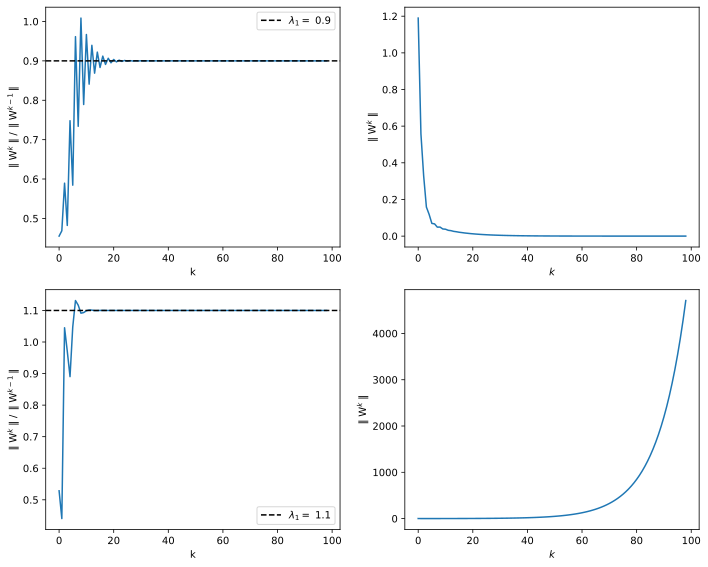

In [16]:
# Plotting
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for j, c in enumerate(norms.keys()):
    ax[j, 0].plot([norms[c][k] / norms[c][k-1] for k in range(1, N)])
    ax[j, 0].axhline(c, color="k", linestyle="dashed", label=r"$\lambda_1 =$" + f" {c}")
    ax[j, 0].set_ylabel(r"$\|\; \boldsymbol{\mathsf{W}}^k \;\| \; / \;\, \|\; \boldsymbol{\mathsf{W}}^{k-1} \,\|$")
    ax[j, 0].set_xlabel("k")
    ax[j, 0].legend()

    # Plotting
    ax[j, 1].plot([norms[c][k] for k in range(1, N)])
    ax[j, 1].set_ylabel(r"$\|\; \boldsymbol{\mathsf{W}}^k \;\|$")
    ax[j, 1].set_xlabel(r"$k$")

fig.tight_layout();